In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/6d28a5c946ff483da9c4e72420804bfc



In [2]:
#!pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI_reshape
# from data import HCP_MRI_crop

In [6]:
 torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:1")
else:
  device = torch.device("cpu")

In [8]:
! nvidia-smi

Mon Mar  8 21:22:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |   4593MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   30C    P0    36W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [9]:
data_dir = pathlib.Path('/data/adni')

In [10]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [11]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
PATH_TO_MRI = '/home/crop_data_resize'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [12]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


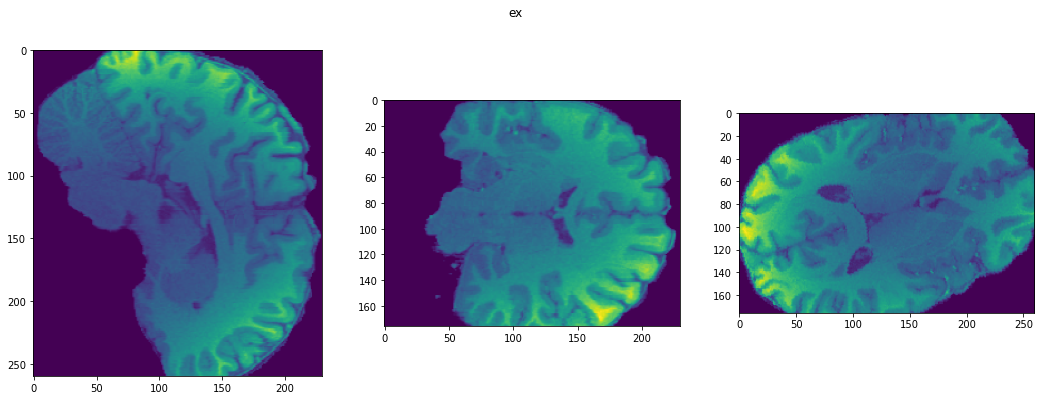

Val example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


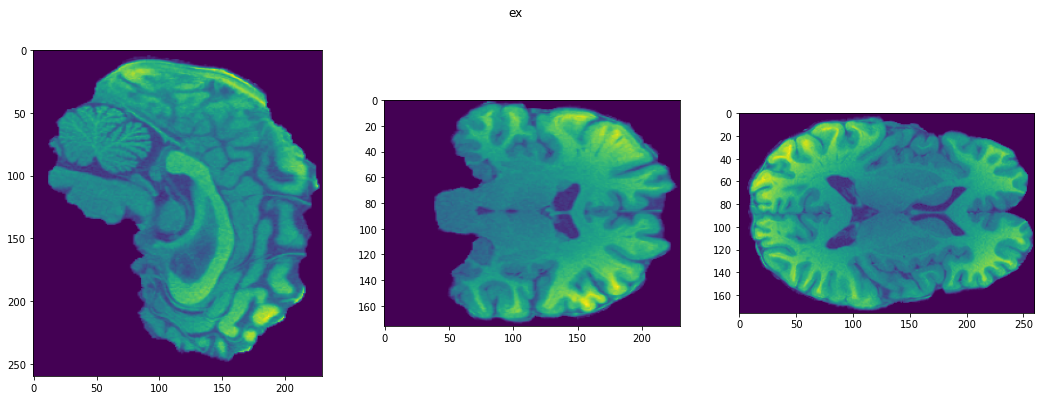

In [13]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 
train_hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(176, 260, 230) #176, 260, 230, (226, 301, 235), 256, 320, 320
)
val_hcp_dataset = HCP_MRI_reshape(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
    img_shape=(176, 260, 230) #176, 260, 230, 226, 301, 235), 256, 320, 320
)

hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 35),
    RandomAffine(degrees = 0, scale=(0.8, 1.1)) #0.8,1.2
#     ToTensor(),
])

val_transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
# train_transform = torchio.transforms.Compose([
# #     BrightnessContrast(),
# #     GaussNoise(),
#     torchio.transforms.RandomAffine(scales=(0.8, 1.2), degrees = 10),
# #     ToTensor(),
# ])

train_hcp_dataset.transform = train_transform
val_hcp_dataset.transform = val_transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [14]:
# import time 
# start_time = time.time()
# img = np.load('/home/crop_data_resize/167743_3T_T1w_MPR1_bet_mask_crop.npy') 
# print( time.time() - start_time)

In [15]:
# import time 
# start_time = time.time()
# img = nib.load('/home/crop_data_resize/167743_3T_T1w_MPR1_bet_mask_crop.nii.gz').get_data() 
# print( time.time() - start_time)

In [52]:
# !rm -r crop_data

rm: cannot remove 'crop_data': No such file or directory


In [31]:
# from skimage.transform import resize
# from skimage import util
# from tqdm import tqdm
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
# mri_paths = {
#             "participant_id": [],
#             "path": []
#         }
# bd = pd.read_csv(behavioral_path)
# bd.set_index('Subject',inplace=True)
# y_gender = []
        
# for patient_folder_name in os.listdir(PATH_TO_MRI):
#     if 'nii' in patient_folder_name:
#             sub = patient_folder_name[:6]
#             if int(sub) in bd.index.values:
#                 full_path = '{}/{}_3T_T1w_MPR1_bet_mask.nii.gz'.format(PATH_TO_MRI, sub)
#                 if os.path.exists(full_path):
#                     mri_paths["participant_id"].append(sub)
#                     mri_paths["path"].append(full_path)
#                     y_gender.append(bd['Gender'][int(sub)])

# mri_paths = pd.DataFrame(mri_paths)
    
# mri_paths['Gender'] = y_gender
# #         print(self.mri_paths['Gender'])
# mri_paths = mri_paths["path"].tolist()
# for nii_path in tqdm(mri_paths):
#             img = nib.load(nii_path).get_data()
#             subj_bool = img != 0
#     #         subj_bool = subj_bool.reshape( (256, 320, 320,1))
#             ax_zero_cut = torch.from_numpy(subj_bool).max(dim=2).values.max(dim=1).values.data.numpy()
#             ax_one_cut = torch.from_numpy(subj_bool).max(dim=2).values.max(dim=0).values.data.numpy()
#             ax_two_cut = torch.from_numpy(subj_bool).max(dim=1).values.max(dim=0).values.data.numpy()
#             ax_zero_min, ax_zero_max = np.where(ax_zero_cut)[0][[0, -1]]
#             ax_one_min, ax_one_max = np.where(ax_one_cut)[0][[0, -1]]
#             ax_two_min, ax_two_max = np.where(ax_two_cut)[0][[0, -1]]
# #             print(img.dtype)
#             img = img[
#                       ax_zero_min:ax_zero_max + 1,
#                       ax_one_min:ax_one_max + 1,
#                       ax_two_min:ax_two_max + 1,
#                       ]
# #             print(img.dtype)
            
# #             plot_central_cuts(img[None,:,:,:], title="ex", t = None)
#             img = util.img_as_int(resize(img, (176, 260, 230)))
            
#             np.save('/home/crop_data_resize_np/{}_3T_T1w_MPR1_bet_mask_crop'.format(nii_path[-34:-28]), img) #-39, -33
#             nib.save(nib.Nifti1Image(img, affine = np.eye(4)), '/home/crop_data_resize/{}_3T_T1w_MPR1_bet_mask_crop.nii.gz'.format(nii_path[-34:-28]))

  0%|          | 0/1112 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
100%|██████████| 1112/1112 [1:20:48<00:00,  4.36s/it]


In [16]:
# !df -h

Filesystem                                 Size  Used Avail Use% Mounted on
overlay                                    3.7T  2.0T  1.7T  55% /
tmpfs                                       64M     0   64M   0% /dev
tmpfs                                       63G     0   63G   0% /sys/fs/cgroup
shm                                         64M  4.0K   64M   1% /dev/shm
192.168.1.2:/home/mri/Druzhinina/project   9.1T  9.1T  1.0M 100% /home
10.30.99.245:/home/datasets/adni            13T   12T   75G 100% /data/adni
192.168.1.2:/home/mri/datasets/HCP_T1_fsl  9.1T  9.1T  1.0M 100% /data/hcp
/dev/sdb1                                  3.7T  2.0T  1.7T  55% /etc/hosts
tmpfs                                       63G   12K   63G   1% /proc/driver/nvidia
/dev/mapper/vg_local-lv_root                28G   14G   13G  53% /usr/bin/nvidia-smi
udev                                        63G     0   63G   0% /dev/nvidia3
tmpfs                                       63G     0   63G   0% /proc/acpi
tmpfs      

In [24]:
# !du

5724	./.ipynb_checkpoints
104	./checkpoints/.ipynb_checkpoints
159111148	./checkpoints
5904	./checkpoints_backup
9552	./masks/.ipynb_checkpoints
40	./masks/__pycache__
4716	./masks/img_without_skulstr/.ipynb_checkpoints
10664	./masks/img_without_skulstr
0	./masks/skull-worked_gradcam/.ipynb_checkpoints
4124	./masks/skull-worked_gradcam
3332	./masks/img_skull/.ipynb_checkpoints
7024	./masks/img_skull
25296	./masks/wandb/run-20201230_041102-3azna7la/logs
9092	./masks/wandb/run-20201230_041102-3azna7la/files/media/images
9092	./masks/wandb/run-20201230_041102-3azna7la/files/media
9128	./masks/wandb/run-20201230_041102-3azna7la/files
34656	./masks/wandb/run-20201230_041102-3azna7la
34656	./masks/wandb
920	./masks/Free_surfer(450)/.ipynb_checkpoints
5016	./masks/Free_surfer(450)
196	./masks/befor
86936	./masks
4	./.git/refs/heads
0	./.git/refs/tags
4	./.git/refs/remotes/origin
4	./.git/refs/remotes
8	./.git/refs
0	./.git/branches
40	./.git/hooks
4	./.git/info
133701312	./.git/objects/pack
0

In [30]:
# !rm -r ./.Trash-0/info/*

In [14]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

# Model structure

In [16]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return train_loss_list, val_loss_list, train_acc_list, val_acc_list    

In [17]:
torch.cuda.empty_cache()

In [18]:
CHECKPOINTS_DIR =  '/home/checkpoints_reshape_without_dropout_3.09/'

In [ ]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2), 
            
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
#             nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [20]:
if torch.cuda.device_count() > 1:
      d_ids= [1,3]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [1, 3] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=1896960, out_features=2, bias=True)


In [22]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [23]:
model_name = '_checkpoints_tr_without_dropout_3.09'
experiment.set_name("3DCNN_checkpoints_tr_without_dropout_3.09")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 60

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

100%|██████████| 112/112 [00:52<00:00,  2.15it/s]


Epoch 00/60 || Loss:  Train 37.0690 | Validation 46.3279


100%|██████████| 112/112 [00:51<00:00,  2.17it/s]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/60 || Loss:  Train 15.7796 | Validation 5.2644 Acc: Train 67.6040 | Validation 82.9596


100%|██████████| 112/112 [00:51<00:00,  2.16it/s]


Epoch 02/60 || Loss:  Train 2.4158 | Validation 6.5624 Acc: Train 87.8515 | Validation 76.6816


100%|██████████| 112/112 [00:51<00:00,  2.16it/s]


Epoch 03/60 || Loss:  Train 2.3665 | Validation 2.2212 Acc: Train 86.9516 | Validation 89.2377


100%|██████████| 112/112 [00:52<00:00,  2.14it/s]


Epoch 04/60 || Loss:  Train 1.9765 | Validation 2.2357 Acc: Train 88.8639 | Validation 88.7892


100%|██████████| 112/112 [00:51<00:00,  2.16it/s]


Epoch 05/60 || Loss:  Train 1.7278 | Validation 1.5799 Acc: Train 89.4263 | Validation 90.1345


100%|██████████| 112/112 [00:52<00:00,  2.15it/s]


Epoch 06/60 || Loss:  Train 1.6305 | Validation 1.1892 Acc: Train 88.9764 | Validation 91.0314


100%|██████████| 112/112 [00:46<00:00,  2.39it/s]


Epoch 07/60 || Loss:  Train 1.4796 | Validation 1.3764 Acc: Train 90.5512 | Validation 90.5830


100%|██████████| 112/112 [00:47<00:00,  2.38it/s]


Epoch 08/60 || Loss:  Train 1.3094 | Validation 3.3481 Acc: Train 90.5512 | Validation 82.9596


100%|██████████| 112/112 [00:47<00:00,  2.35it/s]


Epoch 09/60 || Loss:  Train 1.4156 | Validation 1.9186 Acc: Train 90.2137 | Validation 88.7892


100%|██████████| 112/112 [00:46<00:00,  2.40it/s]


Epoch 10/60 || Loss:  Train 1.3547 | Validation 1.3065 Acc: Train 90.3262 | Validation 91.4798


100%|██████████| 112/112 [00:49<00:00,  2.24it/s]


Epoch 11/60 || Loss:  Train 1.0501 | Validation 1.0511 Acc: Train 90.6637 | Validation 91.4798


100%|██████████| 112/112 [00:47<00:00,  2.38it/s]


Epoch 12/60 || Loss:  Train 0.9020 | Validation 1.0958 Acc: Train 91.1136 | Validation 91.4798


100%|██████████| 112/112 [00:48<00:00,  2.32it/s]


Epoch 13/60 || Loss:  Train 0.9737 | Validation 0.7411 Acc: Train 91.9010 | Validation 91.9283


100%|██████████| 112/112 [00:47<00:00,  2.34it/s]


Epoch 14/60 || Loss:  Train 1.4289 | Validation 1.0417 Acc: Train 89.8763 | Validation 91.4798


100%|██████████| 112/112 [00:47<00:00,  2.36it/s]


Epoch 15/60 || Loss:  Train 0.9501 | Validation 1.0925 Acc: Train 90.4387 | Validation 91.4798


100%|██████████| 112/112 [00:46<00:00,  2.41it/s]


Epoch 16/60 || Loss:  Train 1.2795 | Validation 0.7843 Acc: Train 88.4139 | Validation 93.2735


100%|██████████| 112/112 [00:45<00:00,  2.45it/s]


Epoch 17/60 || Loss:  Train 0.9082 | Validation 0.7196 Acc: Train 92.0135 | Validation 92.3767


100%|██████████| 112/112 [01:13<00:00,  1.53it/s]


Epoch 18/60 || Loss:  Train 1.0236 | Validation 1.2952 Acc: Train 90.5512 | Validation 90.1345


100%|██████████| 112/112 [00:47<00:00,  2.36it/s]


Epoch 19/60 || Loss:  Train 0.9752 | Validation 1.1019 Acc: Train 91.1136 | Validation 90.5830


100%|██████████| 112/112 [01:15<00:00,  1.49it/s]


Epoch 20/60 || Loss:  Train 0.8897 | Validation 0.7344 Acc: Train 91.7885 | Validation 92.8251


100%|██████████| 112/112 [01:10<00:00,  1.58it/s]


Epoch 21/60 || Loss:  Train 0.8277 | Validation 1.1619 Acc: Train 93.7008 | Validation 89.2377


100%|██████████| 112/112 [01:11<00:00,  1.57it/s]


Epoch 22/60 || Loss:  Train 0.9031 | Validation 0.6607 Acc: Train 91.5636 | Validation 92.3767


100%|██████████| 112/112 [01:03<00:00,  1.77it/s]


Epoch 23/60 || Loss:  Train 0.6389 | Validation 0.6948 Acc: Train 93.0259 | Validation 92.3767


100%|██████████| 112/112 [00:52<00:00,  2.13it/s]


Epoch 24/60 || Loss:  Train 0.7847 | Validation 1.0856 Acc: Train 92.4634 | Validation 90.1345


100%|██████████| 112/112 [01:10<00:00,  1.60it/s]


Epoch 25/60 || Loss:  Train 0.5449 | Validation 1.1286 Acc: Train 94.3757 | Validation 90.5830


100%|██████████| 112/112 [00:51<00:00,  2.19it/s]


Epoch 26/60 || Loss:  Train 1.1164 | Validation 0.7390 Acc: Train 90.4387 | Validation 91.9283


100%|██████████| 112/112 [01:00<00:00,  1.84it/s]


Epoch 27/60 || Loss:  Train 0.6493 | Validation 1.0180 Acc: Train 93.7008 | Validation 89.6861


100%|██████████| 112/112 [00:59<00:00,  1.87it/s]


Epoch 28/60 || Loss:  Train 1.0273 | Validation 1.7167 Acc: Train 91.4511 | Validation 86.9955


100%|██████████| 112/112 [01:00<00:00,  1.85it/s]


Epoch 29/60 || Loss:  Train 0.8419 | Validation 2.7316 Acc: Train 91.6760 | Validation 83.4081


100%|██████████| 112/112 [01:01<00:00,  1.83it/s]


Epoch 30/60 || Loss:  Train 0.8461 | Validation 0.8977 Acc: Train 91.3386 | Validation 91.4798


100%|██████████| 112/112 [01:38<00:00,  1.14it/s]


Epoch 31/60 || Loss:  Train 0.6177 | Validation 0.8207 Acc: Train 93.1384 | Validation 92.3767


100%|██████████| 112/112 [01:38<00:00,  1.14it/s]


Epoch 32/60 || Loss:  Train 0.4877 | Validation 1.1747 Acc: Train 94.0382 | Validation 90.1345


In [17]:
!cd /home/checkpoints_torchion_reshape && ls

10_epoch_model__checkpoints_torchio_reshape
15_epoch_model__checkpoints_torchio_reshape
20_epoch_model__checkpoints_torchio_reshape
25_epoch_model__checkpoints_torchio_reshape
30_epoch_model__checkpoints_torchio_reshape
35_epoch_model__checkpoints_torchio_reshape
40_epoch_model__checkpoints_torchio_reshape
45_epoch_model__checkpoints_torchio_reshape
50_epoch_model__checkpoints_torchio_reshape
55_epoch_model__checkpoints_torchio_reshape
5_epoch_model__checkpoints_torchio_reshape
60_epoch_model__checkpoints_torchio_reshape
best_acc_model__checkpoints_torchio_reshape
best_val_loss_model__checkpoints_torchio_reshape


In [17]:
model.load_state_dict(torch.load('/home/checkpoints_torchion_reshape/best_acc_model__checkpoints_torchio_reshape'))
model.eval()

DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [21]:
get_metric(model, val_loader)

100%|██████████| 112/112 [01:20<00:00,  1.40it/s]


(96.41255950927734, 0.9665447154471545, 0.9339622641509434, 0.99)

In [18]:
get_metric(model, train_loader)

100%|██████████| 223/223 [08:13<00:00,  2.21s/it]


(97.30033874511719,
 0.49605452302547737,
 0.45368171021377673,
 0.4692874692874693)

In [19]:
!jupyter notebook list

Currently running servers:
http://0.0.0.0:7777/?token=52067dc4d0bdafdf04de7740f0ae63d858f4dade73c8e919 :: /
